# COVID-ABS: An Agent-Based Model of COVID-19 Epidemic to Simulate Health and Economic Effects of Social Distancing Interventions

## Installing the package

## Common imports

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from matplotlib import animation, rc
from IPython.display import HTML

#from covid_abs.graphics import *
from covid_abs.no_graphics import *
from covid_abs.experiments import *
from covid_abs.network.graph_abs import *
from covid_abs.network.util import *

### Global Parameters

In [2]:
global_parameters = dict(

    # General Parameters
    length=300,
    height=300,

    # Demographic
    population_size=100,
    homemates_avg=3,
    homeless_rate=0.0005,
    amplitudes={
        Status.Susceptible: 10,
        Status.Recovered_Immune: 10,
        Status.Infected: 10
    },

    # Epidemiological
    critical_limit=0.01,
    contagion_rate=.9,
    incubation_time=5,
    contagion_time=10,
    recovering_time=20,

    # Economical
    total_wealth=10000000,
    total_business=9,
    minimum_income=900.0,
    minimum_expense=600.0,
    public_gdp_share=0.1,
    business_gdp_share=0.5,
    unemployment_rate=0.12,
    business_distance=20
)

# Custom code

### Plotting

In [28]:
from covid_abs.no_graphics import  *
import matplotlib as pyplot
from IPython import display

def plot_statistics(statistics):
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
    
    for key in statistics['info'][0]:
        y = [e[key] for e in statistics['info']]

        ax1.plot(np.arange(len(y)), y, label=key)
    ax1.set_title('Infection statistics')
        
    for key in statistics['ecom'][0]:
        y = [e[key] for e in statistics['ecom']]

        ax2.plot(np.arange(len(y)), y, label=key)
    ax2.set_title('Economic statistics')

    ax1.legend()
    ax2.legend()
    plt.show()
    
def plot_single(output, save_plot=False):
    steps_per_episode = output[0]
    episode_losses = output[1]
    losses = output[2]
    actions = output[3]
    rewards = output[4]
    qs = output[5]

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 16))

    n_episodes = len(episode_losses)


    fontsizes = {
        'suptitle': 28,
        'title': 26,
        'legend': 18,
        'axis': 20,
        'ticks': 14
    }

    # Plot loss

    y = list(losses)
    x = np.linspace(0, n_episodes, len(y))
    ax1.plot(x, y, color='#ff1717', alpha=0.5)
    ax1.plot(episode_losses, color='#ff1717')

    ax1.set_title('Loss', fontsize=fontsizes['title'])
    ax1.set_xlabel('Episode', fontsize=fontsizes['axis'])
    ax1.tick_params(axis='both', which='major', labelsize=fontsizes['ticks'])
    ax1.set_yscale('log')

    # Plot actions

    y = list(actions)
    x = np.linspace(0, n_episodes, len(y))
    mov_av = np.convolve(y, np.ones(1000)/1000, mode='valid')
    mov_av_x = np.linspace(0, n_episodes, len(mov_av))
    ax2.scatter(x, y, s=0.1)
    ax2.plot(mov_av_x, mov_av, color='#ff1717', label='Moving average (N=1000)')

    ax2.set_title('Actions', fontsize=fontsizes['title'])
    ax2.set_xlabel('Episode', fontsize=fontsizes['axis'])
    ax2.tick_params(axis='both', which='major', labelsize=fontsizes['ticks'])
    ax2.legend(fontsize=fontsizes['legend'])

    # Plot cumulative rewards

    rewards = list(rewards)
    cum_rewards = []
    for episode_steps in steps_per_episode:
        cum_rewards += list(np.cumsum(rewards[episode_steps[0]:episode_steps[1]]))
    
    y = list(cum_rewards)
    x = np.linspace(0, n_episodes, len(y))
    for i, episode_steps in enumerate(steps_per_episode):
        ax3.plot(x[episode_steps[0]:episode_steps[1]],
                 y[episode_steps[0]:episode_steps[1]],
                 color= '#adc7c9' if i%2 == 0 else '#20adbd')

    mov_av = np.convolve(y, np.ones(3000)/3000, mode='valid')
    mov_av_x = np.linspace(0, n_episodes, len(mov_av))
    ax3.plot(mov_av_x, mov_av, color='red', label='Moving average (N=3000)')

    ax3.set_title('Cumulative rewards', fontsize=fontsizes['title'])
    ax3.set_xlabel('Episode', fontsize=fontsizes['axis'])
    ax3.tick_params(axis='both', which='major', labelsize=fontsizes['ticks'])
    ax3.legend(fontsize=fontsizes['legend'])

    # Plot q values

    y = list(qs)
    x = np.linspace(0, n_episodes, len(y))
    for i, episode_steps in enumerate(steps_per_episode):
        ax4.plot(x[episode_steps[0]:episode_steps[1]],
                 y[episode_steps[0]:episode_steps[1]],
                 color= '#adc7c9' if i%2 == 0 else '#20adbd')
    mov_av = np.convolve(y, np.ones(1000)/1000, mode='valid')
    mov_av_x = np.linspace(0, n_episodes, len(mov_av))
    ax4.plot(mov_av_x, mov_av, color='#ff1717', label='Moving average (N=1000)')

    ax4.set_title('Q values', fontsize=fontsizes['title'])
    ax4.set_xlabel('Episode', fontsize=fontsizes['axis'])
    ax4.tick_params(axis='both', which='major', labelsize=fontsizes['ticks'])
    ax4.legend(fontsize=fontsizes['legend'])
    
    plt.tight_layout()

    if save_plot:
        plt.savefig('plots/LSTM Linear, features{}, hidden{}'.format(state_size, hidden_size) +
                    'episodes{}, batch{} sequence_size{}'.format(n_episodes, BATCH_SIZE, SEQUENCE_SIZE) +
                    'target_update{} steps_per_update{}.png'.format(TARGET_UPDATE, UPDATE_EVERY_N_STEPS))
    plt.show()
    
def plot_multiple(outputs, save_plot=False):

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 16))

    for i in range(len(outputs)):

        steps_per_episode = outputs[i][0]
        episode_losses = outputs[i][1]
        losses = outputs[i][2]
        actions = outputs[i][3]
        rewards = outputs[i][4]
        qs = outputs[i][5]

        n_episodes = len(episode_losses)


        fontsizes = {
            'suptitle': 28,
            'title': 26,
            'legend': 18,
            'axis': 20,
            'ticks': 14
        }

        # Plot loss

        y = list(losses)
        x = np.linspace(0, n_episodes, len(y))
        ax1.plot(x, y, color='#ff1717', alpha=0.5)
        ax1.plot(episode_losses, color='#ff1717')

        ax1.set_title('Loss', fontsize=fontsizes['title'])
        ax1.set_xlabel('Episode', fontsize=fontsizes['axis'])
        ax1.tick_params(axis='both', which='major', labelsize=fontsizes['ticks'])
        ax1.set_yscale('log')

        # Plot actions

        y = list(actions)
        x = np.linspace(0, n_episodes, len(y))
        mov_av = np.convolve(y, np.ones(1000)/1000, mode='valid')
        mov_av_x = np.linspace(0, n_episodes, len(mov_av))
        ax2.scatter(x, y, s=0.1)
        ax2.plot(mov_av_x, mov_av, color='#ff1717', label='Moving average (N=1000)' if i == 0 else '')

        ax2.set_title('Actions', fontsize=fontsizes['title'])
        ax2.set_xlabel('Episode', fontsize=fontsizes['axis'])
        ax2.tick_params(axis='both', which='major', labelsize=fontsizes['ticks'])
        ax2.legend(fontsize=fontsizes['legend'])

        # Plot cumulative rewards

        rewards = list(rewards)
        cum_rewards = []
        for episode_steps in steps_per_episode:
            cum_rewards += list(np.cumsum(rewards[episode_steps[0]:episode_steps[1]]))

        y = cum_rewards
        x = np.linspace(0, n_episodes, len(y))
        for i, episode_steps in enumerate(steps_per_episode):
            ax3.plot(x[episode_steps[0]:episode_steps[1]],
                     y[episode_steps[0]:episode_steps[1]],
                     color= '#adc7c9' if i%2 == 0 else '#20adbd')

        mov_av = np.convolve(y, np.ones(3000)/3000, mode='valid')
        mov_av_x = np.linspace(0, n_episodes, len(mov_av))
        ax3.plot(mov_av_x, mov_av, color='red', label='Moving average (N=3000)' if i == 0 else '')

        ax3.set_title('Cumulative rewards', fontsize=fontsizes['title'])
        ax3.set_xlabel('Episode', fontsize=fontsizes['axis'])
        ax3.tick_params(axis='both', which='major', labelsize=fontsizes['ticks'])
        ax3.legend(fontsize=fontsizes['legend'])

        # Plot q values

        y = list(qs)
        x = np.linspace(0, n_episodes, len(y))
        mov_av = np.convolve(y, np.ones(1000)/1000, mode='valid')
        mov_av_x = np.linspace(0, n_episodes, len(mov_av))
        ax4.scatter(x, y, s=0.1)
        ax4.plot(mov_av_x, mov_av, color='#ff1717', label='Moving average (N=1000)' if i == 0 else '')

        ax4.set_title('Q values', fontsize=fontsizes['title'])
        ax4.set_xlabel('Episode', fontsize=fontsizes['axis'])
        ax4.tick_params(axis='both', which='major', labelsize=fontsizes['ticks'])
        ax4.legend(fontsize=fontsizes['legend'])

    plt.tight_layout()

    if save_plot:
        plt.savefig('plots/LSTM Linear, features{}, hidden{}'.format(state_size, hidden_size) +
                    'episodes{}, batch{} sequence_size{}'.format(n_episodes, BATCH_SIZE, SEQUENCE_SIZE) +
                    'target_update{} steps_per_update{}.png'.format(TARGET_UPDATE, UPDATE_EVERY_N_STEPS))
    plt.show()

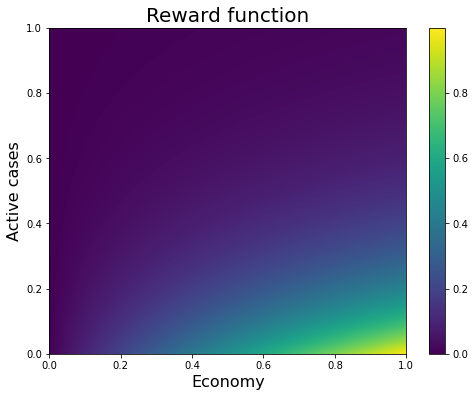

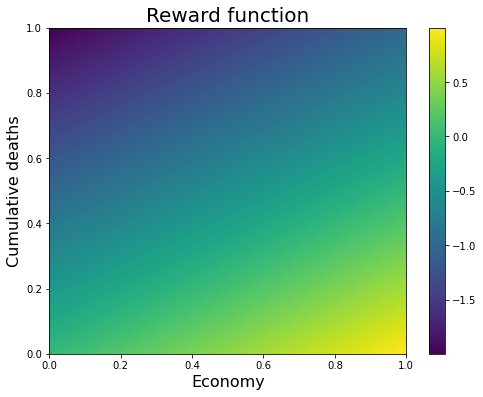

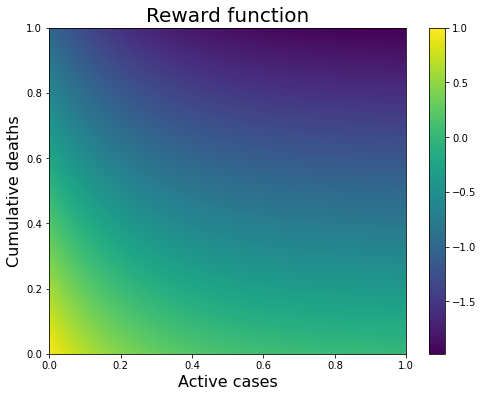

In [4]:
def calc_reward_np(E, A, D, w=1, r=0.1, s=1):
    
    return w * E * np.exp(- r * A * 100) - s * D

def plot_reward(x_i, y_i, w=1, r=1, s=1):
    labels = ['Economy', 'Active cases', 'Cumulative deaths']

    x = np.linspace(0, 1, 1000)
    y = np.linspace(0, 1, 1000)
    xz, yz = np.meshgrid(x, y)
    zeros = np.zeros_like(xz)
    ones = np.ones_like(xz)
    
    if x_i == 0 and y_i == 1:
        rewards = calc_reward_np(xz, yz, zeros, w=w, r=r, s=s)
    elif x_i == 0 and y_i == 2:
        rewards = calc_reward_np(xz, zeros, yz, w=w, r=r, s=s)
    elif x_i == 1 and y_i == 2:
        rewards = calc_reward_np(ones, xz, yz, w=w, r=r, s=s)
    else:
        return
    
    plt.figure(figsize=(8,6))
    plt.title('Reward function', fontsize=20)
    plt.xlabel(labels[x_i], fontsize=16)
    plt.ylabel(labels[y_i], fontsize=16)
    plt.pcolormesh(xz, yz, rewards)
    plt.colorbar()
    plt.show()
    

w = 1
r = 0.04
s = 2
plot_reward(0, 1, w=w, r=r, s=s)
plot_reward(0, 2, w=w, r=r, s=s)
plot_reward(1, 2, w=w, r=r, s=s)

## Example of a typical scenario

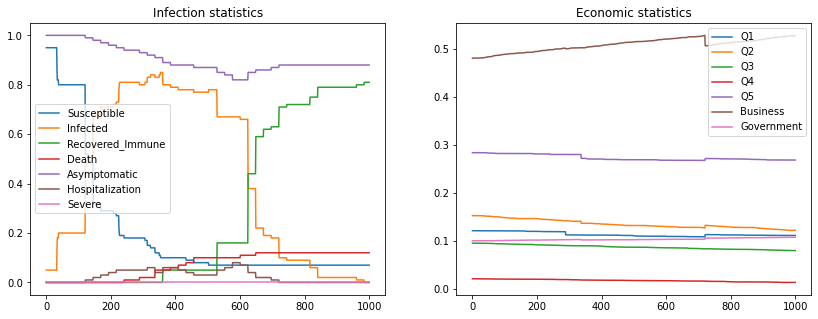

In [5]:
def initialize_scenario(initial_infected_perc=.05):

    return dict(
            name='train_scenario',
            initial_infected_perc=initial_infected_perc,
            initial_immune_perc=.00,
            contagion_distance=1.,
            callbacks={'on_execute': lambda x: sleep(x) }
            )

scenario1 = initialize_scenario()

iterations = []


sim = GraphSimulation(**{**global_parameters, **scenario1})
statistics = execute_simulation(sim, iterations=1000)

plot_statistics(statistics)

### Helpers

In [6]:
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

torch.set_default_dtype(torch.float64)

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))
OptimizerSpec = namedtuple('OptimizerSpec', ['constructor', 'kwargs'])

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    # sample a batch of states
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    # sample random sequences from the replaymemory
    def sample_sequence(self, sequence_length):
        if self.memory[-1].next_state is not None:
            start_index = random.randint(0, len(self)-1-sequence_length)
        else:
            start_index = random.randint(0, len(self)-1)
        
        sequence = deque([], maxlen=sequence_length)
        
        for i in range(start_index, start_index+sequence_length):
            transition = self.memory[i]
            if transition.next_state is None:
                for j in range(0, sequence_length+start_index-i):
                    transition = Transition(transition.state,
                                            transition.action,
                                            transition.state,
                                            transition.reward)
                    sequence.append(transition)
                break
            else:
                sequence.append(transition)
        return list(sequence)
    
    # sample a batch of sequences
    def sample_sequences(self, batch_size, sequence_length):
        return [self.sample_sequence(sequence_length) for i in range(batch_size)]

    def __len__(self):
        return len(self.memory)

In [7]:
def get_previous_action():
    if len(memory) == 0 or memory.memory[-1].next_state is None:
        return 0.0
    else:
        return memory.memory[-1].action.item()

# creates sequence for LSTM starting backwards from the current state
def create_sequence(state):
    x = [torch.tensor(state, device=device)]
    if len(memory) == 0:
        x = x * SEQUENCE_SIZE
    else:
        for count in range(1, SEQUENCE_SIZE):
            i = len(memory) - 1 - count
            if i < 0:
                x = [memory.memory[0].state] * i + x
                break
            elif memory.memory[i].next_state is None:
                x = [memory.memory[i+1].state] * i + x
                break
            else:
                x.insert(0, memory.memory[i].state)
    
    return torch.cat(x).view(1, -1, state_size).to(device)

# General Training loop

In [8]:
def train(model, state_size, n_actions, get_state_func, select_action_func, reward_func, optimize_func, optimizer_spec):
    
    starttime = time.time()
    
    # Initialize metrics
    steps_per_episode = deque([])
    episode_losses = deque([])
    losses = deque([])
    actions = deque([])
    rewards = deque([])
    qs = deque([])
    
    # Initalize policy and target model
    policy_net = model(state_size, n_actions).to(device)
    target_net = model(state_size, n_actions).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()
    
    # Initialize optimizer
    optimizer = optimizer_spec.constructor(policy_net.parameters(), **optimizer_spec.kwargs)
    
    steps_done = 0
    
    scenario1 = initialize_scenario()
    
    for i_episode in range(NUM_EPISODES):
        # Initialize the environment and state
        sim = GraphSimulation(**{**global_parameters, **scenario1})
        statistics = {'info': [], 'ecom': []}
        sim.initialize()
        update_statistics(sim, statistics)
        
        start_steps_done = steps_done
        
        state = get_state_func(statistics)
        for t in count():
            # Select and perform an action
            action = select_action(state, policy_net, steps_done)
            
            _, reward, done, _ = step(sim, statistics, action.item())
            steps_done += 1

            actions.append(action.item())
            rewards.append(reward)
            
            qs.append(torch.max(policy_net(create_sequence(state))).item())

            reward = torch.tensor([reward], device=device)

            # Observe new state
            if not done:
                next_state = get_state(statistics)
            else:
                next_state = None

            # Store the transition in memory
            memory.push(state, action, next_state, reward)

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the policy network)
            
            loss = optimize_func(steps_done, policy_net, target_net, optimizer)
            if loss is not None:
                losses.append(loss)
            
            if done:
                steps_per_episode.append((start_steps_done, steps_done))
                break
        # Update the target network, copying all weights and biases in DQN
        if i_episode % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())
        if len(losses) == 0:
            losses.append(0)
        episode_losses.append(losses[-1])
        print('Episode:', i_episode+1, 'Steps done:', steps_done, 'Loss:', episode_losses[-1])
        
    print('Training took {} seconds.'.format(time.time()-starttime))
    
    return steps_per_episode, episode_losses, losses, actions, rewards, qs

# COVID Scenario

### Necessary functions for this scenario

In [9]:
def lockdown(a):
    if a.house is not None:
        a.house.checkin(a)
    return True

In [10]:
# 0: Susceptible
# 1: Infected
# 2: Recovered_Immune
# 3: Death
# 4: Asymptomatic
# 5: Hospitalization
# 6: Severe
# 7: Q1
# 8: Q2
# 9: Q3
# 10: Q4
# 11: Q5
# 12: Business
# 13: Government
def get_state(statistics):
    state_list = list(statistics['info'][-1].values()) + list(statistics['ecom'][-1].values())
    return torch.tensor([state_list[1], state_list[3], state_list[12], get_previous_action()], device=device)
    #return torch.tensor(list(statistics['info'][-1].values()) + list(statistics['ecom'][-1].values()),
    #                    device=device)

# Action selection method
def select_action(state, policy_net, steps_done):
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    if sample > eps_threshold:
        with torch.no_grad():
            x = create_sequence(state)
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return torch.argmax(policy_net(x)).view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

# Environment step method
def step(sim, statistics, action):
    if action == 1:
        sim.register_callback('on_person_move', lambda x: lockdown(x))
    elif action == 0:
        sim.callbacks.pop('on_person_move', None)
    update(sim, statistics)
    state = get_state(statistics)
    reward = calc_reward(state, action)
    done = sim.terminated()
    
    return _, reward, done, _

# Reward calculation method
def calc_reward(state, action, r=0.04, s=2, g=0.05):
    
    E = state[2].item()
    D = state[1].item()
    A = state[0].item() * 100
    P = state[3].item() != action
    return E * np.exp(- r * A) - s * D - g * P

# Model optimization method
def optimize_model(steps_done, policy_net, target_net, optimizer):
    if len(memory) < BATCH_SIZE * SEQUENCE_SIZE or steps_done % UPDATE_EVERY_N_STEPS != 0:
        return
    
    # Get transitions
    transitions = memory.sample_sequences(BATCH_SIZE, SEQUENCE_SIZE)
    
    # Get batches of sequences
    state_sequence_batch = [transition.state for sequence in transitions for transition in sequence] 
    state_sequence_batch = torch.cat(state_sequence_batch).view(BATCH_SIZE, -1, state_size).to(device)
    next_state_sequence_batch = [transition.next_state for sequence in transitions for transition in sequence]
    next_state_sequence_batch = torch.cat(next_state_sequence_batch).view(BATCH_SIZE, -1, state_size).to(device)
    
    # get batches of last actions and rewards
    action_batch = [sequence[-1].action for sequence in transitions]
    action_batch = torch.cat(action_batch).view(BATCH_SIZE, -1).to(device)
    reward_batch = [sequence[-1].reward for sequence in transitions]
    reward_batch = torch.cat(reward_batch).view(BATCH_SIZE, -1).to(device)
    

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_sequence_batch).gather(1, action_batch)
    
    # Compute V(s_{t+1}) for all next states.
    next_state_values = target_net(next_state_sequence_batch).max(1)[0].detach()
    
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    
    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    last_loss = loss.item()
    
    optimizer.zero_grad()# Resets the gradients
    loss.backward() # Backward pass
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()  # Update parameters
    
    return last_loss


The reward function weights economy, death and infected.

The curious thing is, if you inverse the reward function in this code (*(-1)), the behaviour of the nn inverses and it only chooses action 1 (=lockdown), which is wanted, but the loss increases. This means there is probably a bug in the code or we are misunderstanding something.

The algorithm used for training the LSTM nn is from https://arxiv.org/abs/1507.06527.

### Models

In [22]:
# not used in the current code
class DQNForCov(nn.Module):

    def __init__(self, input_size, output_size):
        super(DQNForCov, self).__init__()
        
        self.linear1 = nn.Linear(input_size, 8)
        self.linear2 = nn.Linear(8, output_size)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.view(-1, 14).to(device)
        x = F.softmax(self.linear1(x))
        x = F.softmax(self.linear2(x))
        return x.view(x.size(0), -1)

# used for this scenario
class LSTMModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LSTMModel, self).__init__()
        
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = 4
        self.num_lstm_layers = SEQUENCE_SIZE
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.num_lstm_layers, batch_first=True, bidirectional=True)
        self.linear1 = nn.Linear(self.hidden_size * 2, self.output_size)
    
    def forward(self, x):
        
        h0 = torch.zeros(self.num_lstm_layers * 2, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_lstm_layers * 2, x.size(0), self.hidden_size).to(device)
        
        out, (h0, c0) = self.lstm(x, (h0, c0))
        
        out = F.softmax(self.linear1(out[:, -1, :]))
        
        return out

### Train

In [23]:
MEMORY_SIZE = 10000

# For training
BATCH_SIZE = 50
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.00
EPS_DECAY = 8000
TARGET_UPDATE = 2
UPDATE_EVERY_N_STEPS = 40

# For model
SEQUENCE_SIZE = 10

# For optimizer
LEARNING_FREQ = 4
LEARNING_RATE = 0.00025
ALPHA = 0.95
EPS = 0.01

NUM_EPISODES = 50

state_size = 4
n_actions = 2

optimizer_spec = OptimizerSpec(
    constructor=optim.RMSprop,
    kwargs=dict(lr=LEARNING_RATE, alpha=ALPHA, eps=EPS)
)

memory = ReplayMemory(MEMORY_SIZE)

# Train once
output = train(LSTMModel, state_size, n_actions, get_state, select_action, calc_reward, optimize_model, optimizer_spec)

# Train multiple times

'''outputs = []

for i in range(10):
    print('Training Nr. {}'.format(i+1))
    output = train(LSTMModel, state_size, n_actions, get_state, select_action, calc_reward, optimize_model, optimizer_spec)
    
    outputs.append(output)'''

Episode: 1 Steps done: 1393 Loss: 0.02094352203407377
Episode: 2 Steps done: 2330 Loss: 0.014578994903971841
Episode: 3 Steps done: 3315 Loss: 0.013326550297075036
Episode: 4 Steps done: 4228 Loss: 0.009984962567322961
Episode: 5 Steps done: 4997 Loss: 0.018390785832508166
Episode: 6 Steps done: 6006 Loss: 0.01135030456738372
Episode: 7 Steps done: 6967 Loss: 0.0081676182832423
Episode: 8 Steps done: 8216 Loss: 0.017496811632853607
Episode: 9 Steps done: 9321 Loss: 0.01802386322371342
Episode: 10 Steps done: 10162 Loss: 0.013167658224620783
Episode: 11 Steps done: 11195 Loss: 0.013195901431341835
Episode: 12 Steps done: 11916 Loss: 0.0063947180312358114
Episode: 13 Steps done: 12901 Loss: 0.014422910760519865
Episode: 14 Steps done: 13862 Loss: 0.01468263392745854
Episode: 15 Steps done: 14463 Loss: 0.009431159694452148
Episode: 16 Steps done: 15160 Loss: 0.015653956863069272
Episode: 17 Steps done: 15761 Loss: 0.0128454937860461
Episode: 18 Steps done: 16410 Loss: 0.01848328887592298


"outputs = []\n\nfor i in range(10):\n    print('Training Nr. {}'.format(i+1))\n    output = train(LSTMModel, state_size, n_actions, get_state, select_action, calc_reward, optimize_model, optimizer_spec)\n    \n    outputs.append(output)"

In [26]:
hidden_size = 4

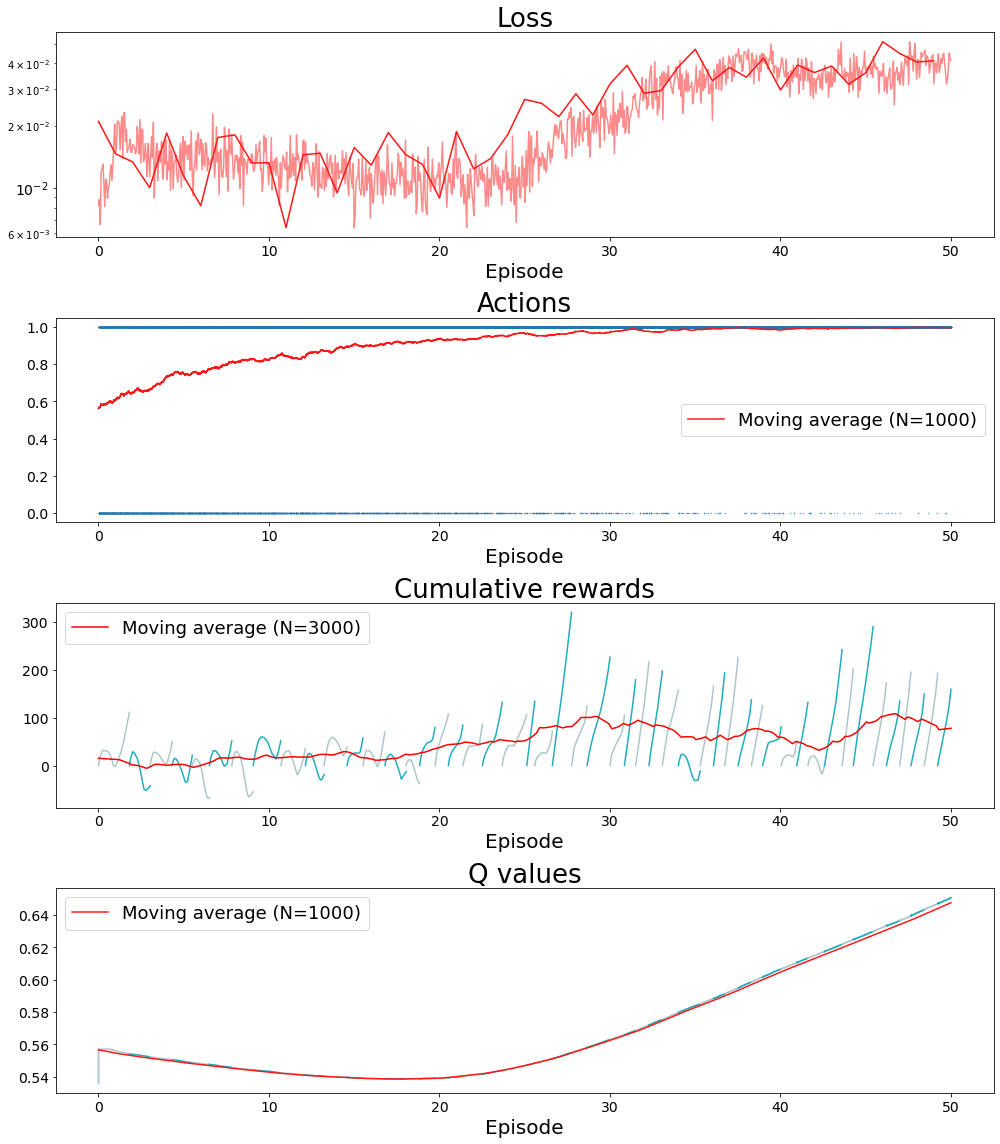

In [29]:
#for i, steps_per_ep

plot_single(output, save_plot=True)
#plot_multiple(outputs)

Only one of the ten training sets converged to the desired outcome: the AI choosing 1 (=lockdown).

# Not our code (not relevant)

## Simulations

### Support Functions

In [ ]:
def pset(x, property, value):
    x.__dict__[property] = value
    return False


def vertical_isolation(a):
  if a.economical_status == EconomicalStatus.Inactive:
    if a.house is not None:
      a.house.checkin(a)
    return True
  return False


def sleep(a):
    if not new_day(a.iteration) and bed_time(a.iteration):
        return True
    #elif 9 <= a.iteration % 24 <= 11 and 14 <= a.iteration % 24 <= 16:
    #    return True
    return False

def lockdown(a):
    if a.house is not None:
        a.house.checkin(a)
    return True


def conditional_lockdown(a):
    if a.environment.get_statistics()['Infected'] > .05:
        return lockdown(a)
    else:
        return False


isolated = []


def sample_isolated(environment, isolation_rate=.5, list_isolated=isolated):
    for a in environment.population:
        test = np.random.rand()
        if test <= isolation_rate:
            list_isolated.append(a.id)


def check_isolation(list_isolated, agent):
    if agent.id in list_isolated:
        agent.move_to_home()
        return True
    return False


### Scenario 1 - No measures

In [ ]:
scenario1 = initialize_scenario()

iterations = []


sim = GraphSimulation(**{**global_parameters, **scenario1})
statistics = execute_simulation(sim, iterations=100)
iterations.append(_iter)
    

plot_statistics(statistics)

In [ ]:
last_info = statistics['info'][-1]
last_ecom = statistics['ecom'][-1]
count = 0
for i in range(len(last_info)):
    print('{}: {}'.format(count, list(last_info.keys())[i]))
    count += 1
for i in range(len(last_ecom)):
    print('{}: {}'.format(count, list(last_ecom.keys())[i]))
    count += 1

### Scenario 2 - Lockdown

In [ ]:
scenario2 = dict(
    name='scenario2',
    initial_infected_perc=.05,
    initial_immune_perc=.00,
    contagion_distance=1.,
    callbacks={
        'on_execute': lambda x: sleep(x),
        'on_person_move': lambda x: lockdown(x)
    }
)

In [ ]:
sim = GraphSimulation(**{**global_parameters, **scenario2})

statistics = execute_simulation(sim, iterations=400)

plot_statistics(statistics)

# Sample code

#### Execution Sample

In [ ]:
from covid_abs.graphics import  *
from covid_abs.network.graph_abs import *
import time

np.random.seed(1)

sim = Simulation(**{**global_parameters, **scenario0})

anim = execute_simulation(sim, iterations=50, iteration_time=200)

#rc('animation', html='jshtml', embed_limit= 2**128)
rc('animation', html='html5', embed_limit= 2**128)
anim

#save_gif(anim, 'do_nothing.gif')

In [ ]:
from covid_abs.graphics import  *
from covid_abs.network.graph_abs import *
import time

np.random.seed(1)

sim = GraphSimulation(**{**global_parameters, **scenario0})

anim = execute_graphsimulation(sim, iterations=1440, iteration_time=50)

#rc('animation', html='jshtml', embed_limit= 2**128)
rc('animation', html='html5', embed_limit= 2**128)
anim

#save_gif(anim, 'do_nothing.gif')

In [ ]:
anim = execute_graphsimulation(sim, iterations=1440, iteration_time=25)

#rc('animation', html='jshtml', embed_limit= 2**128)
rc('animation', html='html5', embed_limit= 2**128)
anim

#### Experiment Batch Execution 

In [ ]:
from covid_abs.network.graph_abs import *

batch_experiment(35, 1440, "scenario0.csv",
                     simulation_type=GraphSimulation,
                     verbose='experiments',
                     **{**global_parameters, **scenario0}
                     )

In [ ]:
from covid_abs.experiments import plot_graph_batch_results

df = pd.read_csv('scenario0.csv')

plot_graph_batch_results(df, epidem=False)

plt.tight_layout()

### Scenario 1 - Do Nothing

In [ ]:
scenario1 = dict(
    name='scenario1',
    initial_infected_perc=.01,
    initial_immune_perc=.01,
    contagion_distance=1.,
    callbacks={'on_execute': lambda x: sleep(x) }
)

#### Execution Sample

In [ ]:
from covid_abs.graphics import  *
from covid_abs.network.graph_abs import *

np.random.seed(1)

sim = GraphSimulation(**{**global_parameters, **scenario1})

anim = execute_graphsimulation(sim, iterations=1440, iteration_time=25)

#rc('animation', html='jshtml', embed_limit= 2**128)
rc('animation', html='html5', embed_limit= 2**128)
anim

#save_gif(anim, 'do_nothing.gif')

#### Experiment Batch Execution 

In [ ]:
from covid_abs.network.graph_abs import *

batch_experiment(35, 1440, "scenario1.csv",
                     simulation_type=GraphSimulation,
                     verbose='experiments',
                     **{**global_parameters, **scenario1}
                     )

In [ ]:
from covid_abs.experiments import plot_graph_batch_results

df = pd.read_csv('scenario1.csv')

plot_graph_batch_results(df)

plt.tight_layout()

### Scenario 2 - Lockdown

In [ ]:
scenario2 = dict(
    name='scenario2',
    initial_infected_perc=.01,
    initial_immune_perc=.01,
    contagion_distance=1.,
    callbacks={
        'on_execute': lambda x: sleep(x),
        'on_person_move': lambda x: lockdown(x)
    }
)

#### Execution Sample

In [ ]:
from covid_abs.graphics import  *
from covid_abs.network.graph_abs import *

np.random.seed(1)

sim = GraphSimulation(**{**global_parameters, **scenario2})

anim = execute_graphsimulation(sim, iterations=1440, iteration_time=25)

#rc('animation', html='jshtml', embed_limit= 2**128)
rc('animation', html='html5', embed_limit= 2**128)
anim

#save_gif(anim, 'do_nothing.gif')

#### Experiment Batch Execution 

In [ ]:
from covid_abs.network.graph_abs import *

batch_experiment(35, 1440, "scenario2.csv",
                     simulation_type=GraphSimulation,
                     verbose='experiments',
                     **{**global_parameters, **scenario2}
                     )

In [ ]:
from covid_abs.experiments import plot_graph_batch_results

df = pd.read_csv('scenario2.csv')

plot_graph_batch_results(df)

plt.tight_layout()

### Scenario 3 - Conditional Lockdown

In [ ]:
scenario3 = dict(
    name='scenario3',
    initial_infected_perc=.01,
    initial_immune_perc=.01,
    contagion_distance=1.,
    callbacks={
        'on_execute': lambda x: sleep(x),
        'on_person_move': lambda x: conditional_lockdown(x)
    }
)

#### Execution Sample

In [ ]:
from covid_abs.graphics import  *
from covid_abs.network.graph_abs import *

np.random.seed(1)

sim = GraphSimulation(**{**global_parameters, **scenario3})

anim = execute_graphsimulation(sim, iterations=1440, iteration_time=25)

#rc('animation', html='jshtml', embed_limit= 2**128)
rc('animation', html='html5', embed_limit= 2**128)
anim

#save_gif(anim, 'do_nothing.gif')

#### Experiment Batch Execution 

In [ ]:
from covid_abs.network.graph_abs import *

batch_experiment(35, 1440, "scenario3.csv",
                     simulation_type=GraphSimulation,
                     verbose='experiments',
                     **{**global_parameters, **scenario3}
                     )

In [ ]:
from covid_abs.experiments import plot_graph_batch_results

df = pd.read_csv('scenario3.csv')

plot_graph_batch_results(df)

plt.tight_layout()

### Scenario 4 - Vertical Isolation


In [ ]:
scenario4 = dict(
    name='scenario4',
    initial_infected_perc=.01,
    initial_immune_perc=.01,
    contagion_distance=1.,
    callbacks={
        'on_execute': lambda x: sleep(x),
        'on_person_move': lambda x: vertical_isolation(x)
    }
)

#### Execution Sample

In [ ]:
from covid_abs.graphics import  *
from covid_abs.network.graph_abs import *

np.random.seed(1)

sim = GraphSimulation(**{**global_parameters, **scenario4})

anim = execute_graphsimulation(sim, iterations=1440, iteration_time=25)

#rc('animation', html='jshtml', embed_limit= 2**128)
rc('animation', html='html5', embed_limit= 2**128)
anim

#save_gif(anim, 'do_nothing.gif')

#### Experiment Batch Execution 

In [ ]:
from covid_abs.network.graph_abs import *

batch_experiment(35, 1440, "scenario4.csv",
                     simulation_type=GraphSimulation,
                     verbose='experiments',
                     **{**global_parameters, **scenario4}
                     )

In [ ]:
from covid_abs.experiments import plot_graph_batch_results

df = pd.read_csv('scenario4.csv')

plot_graph_batch_results(df)

plt.tight_layout()

### Scenario 5 - 50% of Population Isolation

In [ ]:
isolated = []
scenario5 = dict(
    name='scenario5',
    initial_infected_perc=.01,
    initial_immune_perc=.01,
    contagion_distance=1.,
    callbacks={
        #'on_execute': lambda x: sleep(x),
        'post_initialize': lambda x: sample_isolated(x, isolation_rate=.7, list_isolated=isolated),
        'on_person_move': lambda x: check_isolation(isolated, x)
    }
)

#### Execution Sample

In [ ]:
from covid_abs.graphics import  *
from covid_abs.network.graph_abs import *

np.random.seed(1)

sim = GraphSimulation(**{**global_parameters, **scenario5})

anim = execute_graphsimulation(sim, iterations=1440, iteration_time=25)

#rc('animation', html='jshtml', embed_limit= 2**128)
rc('animation', html='html5', embed_limit= 2**128)
anim

#save_gif(anim, 'do_nothing.gif')

#### Experiment Batch Execution 

In [ ]:
from covid_abs.network.graph_abs import *

batch_experiment(35, 1440, "scenario5.csv",
                     simulation_type=GraphSimulation,
                     verbose='experiments',
                     **{**global_parameters, **scenario5}
                     )

In [ ]:
from covid_abs.experiments import plot_graph_batch_results

df = pd.read_csv('scenario5.csv')

plot_graph_batch_results(df)

plt.tight_layout()

#### Other isolation levels

In [ ]:
scenarios = []

for rate in [.4, .5, .6, .7, .8, .9]:
    tmp = dict(
        name='partialisolation{}'.format(rate),
        initial_infected_perc=.01,
        initial_immune_perc=.01,
        contagion_distance=.05,
        callbacks={
            'post_initialize': lambda x: sample_isolated(x, isolation_rate=rate, list_isolated=isolated),
            'on_person_move': lambda x: check_isolation(isolated, x)
        }
    )
    scenarios.append(tmp)
    
for scenario in scenarios:  #scenario0, scenario1, scenario2, scenario3, scenario4, scenario5, scenario6, scenario7, scenario8, scenario9]:
    batch_experiment(15, 1440, "{}.csv".format(scenario['name']),
                     simulation_type=GraphSimulation,
                     verbose='experiments',
                     **{**global_parameters, **scenario}
                     )

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[10, 3])
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                                   AutoMinorLocator)

isolation_levels = [.3, .4, .5, .6, .7, .8, .9]

tick_unit=72

x = [i for i in range(0, 1440)]

for ct, isolation_level in enumerate(isolation_levels):
  df = pd.read_csv('partialisolation{}.csv'.format(isolation_level))
  df2 = df[(df['Metric'] == 'Infected')]
  ax.plot(x, df2['Avg'].values, label=str(isolation_level))
  #print(str(isolation_level), max(df2['Avg'].values))

#ax.set_title("Infection Curve by Isolation Level")
ax.set_ylabel("% of population")
ax.set_xlabel("Days")
tickslabels = [str(i//24) for i in range(0, 1440, tick_unit)]
ax.xaxis.set_major_locator(MultipleLocator(tick_unit))
ax.set_xticklabels(tickslabels)

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='top right')


In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[10, 3])
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                                   AutoMinorLocator)

isolation_levels = [.3, .4, .5, .6, .7, .8, .9]

tick_unit=72

x = [i for i in range(0, 1440)]

for ct, isolation_level in enumerate(isolation_levels):
  df = pd.read_csv('partialisolation{}.csv'.format(isolation_level))
  df2 = df[(df['Metric'] == 'Q5')]
  ax.plot(x, df2['Avg'].values, label=str(isolation_level))
  #print(str(isolation_level), max(df2['Avg'].values))

#ax.set_title("Infection Curve by Isolation Level")
ax.set_ylabel("% of GDP")
ax.set_xlabel("Days")
tickslabels = [str(i//24) for i in range(0, 1440, tick_unit)]
ax.xaxis.set_major_locator(MultipleLocator(tick_unit))
ax.set_xticklabels(tickslabels)

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='top right')


In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=[7, 5])
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                                   AutoMinorLocator)

deaths = []
i_peak = []
vals = []
errs = []
isolation_levels = (.4, .5, .6, .7, .8, .9)

for isolation_level in isolation_levels:
  df = pd.read_csv('partialisolation{}.csv2'.format(isolation_level))
  df2 = df[(df['Metric'] == 'Infected')]
  #min_max = np.max(df2['Min'].values)
  avg_max = np.max(df2['Avg'].values)
  i_peak.append(avg_max)
  #max_max = np.max(df2['Max'].values)
  it_max = np.min(df2[(df['Avg'] == avg_max)]['Iteration'].values)
  #ax.plot(df2['Avg'].values, label=get_label(i))
  vals.append(it_max // 24)

  df3 = df[(df['Metric'] == 'Death')]
  avg_max2 = np.max(df3['Avg'].values)
  deaths.append(avg_max2)

ix = [1,2,3,4,5,6]

ax[0].bar(ix, i_peak, color='white',  edgecolor='black', hatch='//')
ax[0].set_ylabel("% of Infected")
ax[0].set_xlabel("Scenario")
ax[0].set_title("$I_P$ - Infection Peak")

ax[1].bar(ix, vals, color='white',  edgecolor='black', hatch='//')
ax[1].set_ylabel("Number of Days")
ax[1].set_xlabel("Scenario")
ax[1].set_title("$T_{IP}$ - Number of Days to Reach $I_P$")

ax[2].bar(ix, deaths, color='white',  edgecolor='black', hatch='//')
ax[2].set_ylabel("% of Deaths")
ax[2].set_xlabel("Scenario")
ax[2].set_title("$D_t$ - Total Number of Deaths")

plt.tight_layout()


In [ ]:
def next(it, its, start):
  if it not in its:
    for k in its[start:]:
      if k > it:
        return k
  else:
    return it

for sc in [.3]: #.4, .5, .6, .7, .8, .9]:

  filename = 'partialisolation{}.csv'.format(sc)

  df = pd.read_csv(filename)
  metrics = df['Metric'].unique()
  iterations = df['Iteration'].unique()
  columns = ['Min','Avg','Std','Max']
  rows = []
  last_ix = 0
  for iteration in range(0,1440):

    print(iteration)

    ix = next(iteration, iterations, last_ix)

    for metric in metrics:
      row = [iteration, metric]
      for column in columns:
        row.append(df[(df['Iteration']==ix) & (df['Metric']==metric)][column].values[0])

      rows.append(row)

    last_ix = int(np.where(iterations == ix)[0])

  df2 = pd.DataFrame(rows, columns=['Iteration','Metric','Min','Avg','Std','Max'])

  df2.to_csv(filename)
  

### Scenario 6 - Use of Masks

In [ ]:
scenario6 = dict(
    name='scenario6',
    initial_infected_perc=.01,
    initial_immune_perc=.01,
    contagion_distance=.05,
    callbacks={
        'on_execute': lambda x: sleep(x) ,
        'on_initialize': lambda x: pset(x, 'contagion_rate', 0.1)
    }
)

#### Execution Sample

In [ ]:
from covid_abs.graphics import  *
from covid_abs.network.graph_abs import *

np.random.seed(1)

sim = GraphSimulation(**{**global_parameters, **scenario6})

anim = execute_graphsimulation(sim, iterations=1440, iteration_time=25)

#rc('animation', html='jshtml', embed_limit= 2**128)
rc('animation', html='html5', embed_limit= 2**128)
anim

#save_gif(anim, 'do_nothing.gif')

#### Experiment Batch Execution 

In [ ]:
from covid_abs.network.graph_abs import *

batch_experiment(35, 1440, "scenario6.csv",
                     simulation_type=GraphSimulation,
                     verbose='experiments',
                     **{**global_parameters, **scenario8}
                     )

In [ ]:
from covid_abs.experiments import plot_graph_batch_results

df = pd.read_csv('scenario6.csv')

plot_graph_batch_results(df)

plt.tight_layout()

### Scenario 7 - Masks And 50% of Social Isolation

In [ ]:
scenario7 = dict(
    name='scenario7',
    initial_infected_perc=.01,
    initial_immune_perc=.01,
    contagion_distance=.05,
    callbacks={
        'on_execute': lambda x: sleep(x) ,
        'post_initialize': lambda x: sample_isolated(x, isolation_rate=.6, list_isolated=isolated),
        'on_person_move': lambda x: check_isolation(isolated, x),
        'on_initialize': lambda x: pset(x, 'contagion_rate', 0.1)
    }
)

#### Execution Sample

In [ ]:
from covid_abs.graphics import  *
from covid_abs.network.graph_abs import *

np.random.seed(1)

sim = GraphSimulation(**{**global_parameters, **scenario7})

anim = execute_graphsimulation(sim, iterations=1440, iteration_time=25)

#rc('animation', html='jshtml', embed_limit= 2**128)
rc('animation', html='html5', embed_limit= 2**128)
anim

#save_gif(anim, 'do_nothing.gif')

#### Experiment Batch Execution 

In [ ]:
from covid_abs.network.graph_abs import *

batch_experiment(35, 1440, "scenario7.csv",
                     simulation_type=GraphSimulation,
                     verbose='experiments',
                     **{**global_parameters, **scenario9}
                     )

In [ ]:
from covid_abs.experiments import plot_graph_batch_results

df = pd.read_csv('scenario7.csv')

plot_graph_batch_results(df)

plt.tight_layout()

## Analysis

Acho que devemos fazer uma análise qualitativa dos gráficos e uma análise quantitativa e comparativa dos cenários em termos das seguintes métricas:
- número total de mortes 
- número total de infectados
- tempo do pico 
- perdas % em renda das empresas em relação ao cenário 0 
- perdas % em renda das famílias em relação ao cenário 0


### Common Codes

In [ ]:
def get_label(ix):
  return 'Scenario {}'.format(ix)

def get_name(ix):
  return 'scenario{}'.format(ix)

def get_df(ix):
  return pd.read_csv(get_name(ix)+".csv")

#get_df(0).head()

### Evolution of Deaths by Scenario

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[10, 5])
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                                   AutoMinorLocator)
for i in range(1,8):
  df = get_df(i)[['Iteration','Metric','Avg']]
  df2 = df[(df['Metric'] == 'Death')]
  ax.plot(df2['Avg'].values, label=get_label(i))

tick_unit=72

ax.set_title("Evolution of Deaths by Scenario")
ax.set_ylabel("% of population")
ax.set_xlabel("Days")
tickslabels = [str(i//24) for i in range(0, 1440, tick_unit)]
ax.xaxis.set_major_locator(MultipleLocator(tick_unit))
ax.set_xticklabels(tickslabels)

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='top right')

### Evolution of Infection by Scenario

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[10, 5])
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                                   AutoMinorLocator)
for i in range(1,8):
  df = get_df(i)[['Iteration','Metric','Avg']]
  df2 = df[(df['Metric'] == 'Infected')]
  ax.plot(df2['Avg'].values, label=get_label(i))

tick_unit=72

ax.set_title("Evolution of Infection by Scenario")
ax.set_ylabel("% of population")
ax.set_xlabel("Days")
tickslabels = [str(i//24) for i in range(0, 1440, tick_unit)]
ax.xaxis.set_major_locator(MultipleLocator(tick_unit))
ax.set_xticklabels(tickslabels)

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='top right')

### Number of Days to Reach the Infection Peak

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=[7, 5])
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                                   AutoMinorLocator)

deaths = []
i_peak = []
vals = []
errs = []
for i in range(1,8):
  df = get_df(i)
  df2 = df[(df['Metric'] == 'Infected')]
  #min_max = np.max(df2['Min'].values)
  avg_max = np.max(df2['Avg'].values)
  i_peak.append(avg_max)
  #max_max = np.max(df2['Max'].values)
  it_max = np.min(df2[(df['Avg'] == avg_max)]['Iteration'].values)
  #ax.plot(df2['Avg'].values, label=get_label(i))
  vals.append(it_max // 24)

  df3 = df[(df['Metric'] == 'Death')]
  avg_max2 = np.max(df3['Avg'].values)
  deaths.append(avg_max2)

ax[0].bar([i for i in range(1,8)], i_peak, color='white',  edgecolor='black', hatch='//')
ax[0].set_ylabel("% of Infected")
ax[0].set_xlabel("Scenario")
ax[0].set_title("$I_P$ - Infection Peak")

ax[1].bar([i for i in range(1,8)], vals, color='white',  edgecolor='black', hatch='//')
ax[1].set_ylabel("Number of Days")
ax[1].set_xlabel("Scenario")
ax[1].set_title("$T_{IP}$ - Number of Days to Reach $I_P$")

ax[2].bar([i for i in range(1,8)], deaths, color='white',  edgecolor='black', hatch='//')
ax[2].set_ylabel("% of Deaths")
ax[2].set_xlabel("Scenario")
ax[2].set_title("$D_t$ - Total Number of Deaths")

plt.tight_layout()


### GDP Evolution By Social Stratum and Scenario

In [ ]:
from covid_abs.graphics import legend_ecom
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

metrics = legend_ecom.keys()

fig, ax = plt.subplots(nrows=len(metrics), ncols=1, figsize=[10, 25])

tick_unit=72

for i in range(0,10):                                   
  df = get_df(i)[['Iteration','Metric','Avg']]

  for cm, metric in enumerate(metrics):
    df2 = df[(df['Metric'] == metric)]
    ax[cm].plot(df2['Avg'].values, label=get_label(i))

tickslabels = [str(i//24) for i in range(0, 1440, tick_unit)]

for cm, metric in enumerate(metrics):
  ax[cm].set_title(legend_ecom[metric])
  ax[cm].set_ylabel("% of GDP")
  ax[cm].set_xlabel("Days")
  ax[cm].xaxis.set_major_locator(MultipleLocator(tick_unit))
  ax[cm].set_xticklabels(tickslabels)

  handles, labels = ax[cm].get_legend_handles_labels()
  lgd = ax[cm].legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))

plt.tight_layout()

### Scenarios Final GDP Compared with Scenario 0

In [ ]:
from covid_abs.graphics import legend_ecom
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

A1 = ['Q1','Q2','Q3','Q4','Q5']

legend = {'A1': '$W^{A1}_s$ - People',
          'Business': '$W^{A3}_s$ - Business',
          'Government': '$W^{A4}_s$ - Government',}

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=[10, 7])

metrics = [k for k in legend.keys()]

baseline = {'A1': 0.0 }
baseline_stop = {'A1': 0.0 }
df = get_df(0)
for cm, metric in enumerate(legend_ecom.keys()):
  #mn_it = np.min(df['Iteration'].values)
  mx_it = np.max(df['Iteration'].values)
  _start = df[(df['Metric'] == metric) & (df['Iteration'] == 0)]['Avg'].values[-1]
  _stop = df[(df['Metric'] == metric) & (df['Iteration'] == mx_it)]['Avg'].values[-1]
  #_std = df[(df['Metric'] == metric) & (df['Iteration'] == mx_it)]['Std'].values[-1]
  diff = _start - _stop
  #baseline[metric].append(diff)
  if metric in A1:
    #baseline['A1'] += _stop
    baseline['A1'] += diff
    baseline_stop['A1'] += _stop
  else:
    baseline[metric] = diff
    baseline_stop[metric] = _stop

values = {}
colors = {}
std = {}

for i in range(1,8):                                   
  df = get_df(i)
  for cm, metric in enumerate(metrics):
    if metric not in values:
      values[metric] = []
      colors[metric] = []
      std[metric] = []
    
    mx_it = np.max(df['Iteration'].values)

    if metric == 'A1':
      _stop = 0
      _std = 0
      for m2 in A1:
        _stop += df[(df['Metric'] == m2) & (df['Iteration'] == mx_it)]['Avg'].values[-1]
        _std += df[(df['Metric'] == m2) & (df['Iteration'] == mx_it)]['Std'].values[-1]

    else:
      _stop = df[(df['Metric'] == metric) & (df['Iteration'] == mx_it)]['Avg'].values[-1]
      _std = df[(df['Metric'] == metric) & (df['Iteration'] == mx_it)]['Std'].values[-1]
    
    #m = (_stop - baseline[metric])/baseline[metric]
    m = (_stop - baseline_stop[metric])/baseline_stop[metric]
    values[metric].append(m)
    colors[metric].append('//' if m >= 0 else '\\\\' )
    #diff = _start - _stop
    #values[metric].append(diff)
    std[metric].append(_std)
    #colors[metric].append('blue' if diff >= 0 else 'red' )
    #baseline[metric] = _start - stop
    

for cm, metric in enumerate(metrics):
  bars = ax[cm].bar([i for i in range(1,8)], values[metric], color='white',  edgecolor='black',
                    capsize=7, yerr=std[metric])
  for ix, bar in enumerate(bars):
    bar.set_hatch(colors[metric][ix])
  ax[cm].set_ylim([-.25, .25])
  ax[cm].set_ylabel("% of GDP")
  ax[cm].set_xlabel("Scenario")
  ax[cm].set_title(legend[metric])
  ax[cm].axhline(y=0, color='black')


plt.tight_layout()


In [ ]:
def next(it, its, start):
  if it not in its:
    for k in its[start:]:
      if k > it:
        return k
  else:
    return it

for sc in range(2,8):

  filename = 'scenario{}.csv'.format(sc)

  df = pd.read_csv(filename)
  metrics = df['Metric'].unique()
  iterations = df['Iteration'].unique()
  columns = ['Min','Avg','Std','Max']
  rows = []
  last_ix = 0
  for iteration in range(0,1440):

    print(iteration)

    ix = next(iteration, iterations, last_ix)

    for metric in metrics:
      row = [iteration, metric]
      for column in columns:
        row.append(df[(df['Iteration']==ix) & (df['Metric']==metric)][column].values[0])

      rows.append(row)

    last_ix = int(np.where(iterations == ix)[0])

  df2 = pd.DataFrame(rows, columns=['Iteration','Metric','Min','Avg','Std','Max'])

  df2.to_csv(filename + '2')
  

In [ ]:

def plot_graph_batch_results(df, health_metrics=('Susceptible', 'Infected', 'Hospitalization', 'Severe', 'Recovered_Immune', 'Death'),
                       ecom_metrics=('Q1', 'Q2', 'Q3', 'Q4', 'Q5','Business','Government'), **kwargs):

    from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                                   AutoMinorLocator)

    iterations = max(df['Iteration'].values) + 1

    tick_unit = kwargs.get('tick_unit', 72)

    tickslabels = [str(i // 24) for i in range(0, iterations, tick_unit)]

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[20, 5])

    ax[0].set_title('Average Contagion Evolution')
    ax[0].set_xlabel("Nº of Days")
    ax[0].set_ylabel("% of Population")
    ax[0].set_xlim((0, iterations))
    ax[0].xaxis.set_major_locator(MultipleLocator(tick_unit))
    ax[0].set_xticklabels(tickslabels)

    for col in health_metrics:
        means = df[(df["Metric"] == col)]['Avg'].values
        std = df[(df["Metric"] == col)]['Std'].values
        plot_mean_std(ax[0], means, std, legend=col, color=color1(col))

    handles, labels = ax[0].get_legend_handles_labels()
    lgd = ax[0].legend(handles, labels, loc='top right')

    ax[1].set_title('Average Economical Impact')
    ax[1].set_xlabel("Nº of Days")
    ax[1].set_ylabel("% of Wealth")
    ax[1].set_xlim((0, iterations))
    ax[1].xaxis.set_major_locator(MultipleLocator(tick_unit))
    ax[1].set_xticklabels(tickslabels)

    for col in ecom_metrics:
        means = df[(df["Metric"] == col)]['Avg'].values
        #n_mean = np.interp(means, (mmin, mmax), (0, 1))
        std = df[(df["Metric"] == col)]['Std'].values
        #n_std = np.interp(std, (smin, smax), (0, 1))
        #ax[1].plot(means, label=legend_ecom[col])
        # std = np.log10(df[(df["Metric"] == col)]['Std'].values)
        plot_mean_std(ax[1], means, std, legend=legend_ecom[col], color=color3(col))

    handles, labels = ax[1].get_legend_handles_labels()
    lgd = ax[1].legend(handles, labels, loc='top left')

In [ ]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                                   AutoMinorLocator)
from covid_abs.graphics import color3
from covid_abs.experiments import plot_mean_std

A1 = ['Q1','Q2','Q3','Q4','Q5']

health_metrics=('Susceptible', 'Infected', 'Hospitalization', 'Severe', 'Recovered_Immune', 'Death')
ecom_metrics=('Q1', 'Q2', 'Q3', 'Q4', 'Q5','Business','Government')

health_legend={'Susceptible': '$S_t$ - Susceptible', 'Infected':'$I_t$ - Infected', 
               'Hospitalization':'$S^H_t$ - Hospitalization', 'Severe':'$I^S_t$ - Severe', 
               'Recovered_Immune':'$R_t$ - Recovered', 'Death':'$D_t$ - Death'}

ecom_legend = {'A1': '$W^{A1}_t$ - People',
          'Business': '$W^{A3}_t$ - Business',
          'Government': '$W^{A4}_t$ - Government',}

colors = {'A1': 'purple',
          'Business': 'red',
          'Government': 'brown',}

df = get_df(0)

epidem = False

iterations = max(df['Iteration'].values) + 1

tick_unit = 72 #kwargs.get('tick_unit', 72)

tickslabels = [str(i // 24) for i in range(0, iterations, tick_unit)]



fig, ax = plt.subplots(nrows=1, ncols=1 if not epidem else 2,
                       figsize=[7, 4])

if epidem:
  ep_ax = ax[0]
  ep_ax.set_title('Average Epidemiological Evolution')
  ep_ax.set_xlabel("Nº of Days")
  ep_ax.set_ylabel("% of Population")
  ep_ax.set_xlim((0, iterations))
  ep_ax.xaxis.set_major_locator(MultipleLocator(tick_unit))
  ep_ax.set_xticklabels(tickslabels)

  for col in health_metrics:
      means = df[(df["Metric"] == col)]['Avg'].values
      std = df[(df["Metric"] == col)]['Std'].values
      plot_mean_std(ep_ax, means, std, legend=health_legend[col], color=color1(col))

  handles, labels = ep_ax.get_legend_handles_labels()
  lgd = ep_ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))

ec_ax = ax[1] if epidem else ax

ec_ax.set_title('Average Economical Impact')
ec_ax.set_xlabel("Nº of Days")
ec_ax.set_ylabel("% of GDP")
ec_ax.set_xlim((0, iterations))
ec_ax.xaxis.set_major_locator(MultipleLocator(tick_unit))
ec_ax.set_xticklabels(tickslabels)

for col in ecom_legend.keys():
  if col == 'A1':
    means = np.zeros(iterations)
    std = np.zeros(iterations)
    for m2 in A1: 
      means += df[(df["Metric"] == m2)]['Avg'].values  
      std += df[(df["Metric"] == m2)]['Std'].values
  else:  
    means = df[(df["Metric"] == col)]['Avg'].values
    std = df[(df["Metric"] == col)]['Std'].values

  #print(means)
      
  l = len(means)
  lb = [means[k] - std[k] for k in range(l)]
  ub = [means[k] + std[k] for k in range(l)]

  ec_ax.fill_between(range(l), ub, lb,
                  color=colors[col], alpha=.4)
  # plot the mean on top
  ec_ax.plot(range(l), means, colors[col], label=ecom_legend[col])

handles, labels = ec_ax.get_legend_handles_labels()
lgd = ec_ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))

plt.tight_layout()


In [ ]:
from covid_abs.graphics import legend_ecom
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

A1 = ['Q1','Q2','Q3','Q4','Q5']

legend = {'A1': '$W^{A1}_s$ - People',
          'Business': '$W^{A3}_s$ - Business',
          'Government': '$W^{A4}_s$ - Government',}

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=[12, 4])

metrics = [k for k in legend.keys()]

baseline = {'A1': 0.0 }
baseline_stop = {'A1': 0.0 }
df = get_df(0)
for cm, metric in enumerate(legend_ecom.keys()):
  #mn_it = np.min(df['Iteration'].values)
  mx_it = np.max(df['Iteration'].values)
  _start = df[(df['Metric'] == metric) & (df['Iteration'] == 0)]['Avg'].values[-1]
  _stop = df[(df['Metric'] == metric) & (df['Iteration'] == mx_it)]['Avg'].values[-1]
  #_std = df[(df['Metric'] == metric) & (df['Iteration'] == mx_it)]['Std'].values[-1]
  diff = _start - _stop
  #baseline[metric].append(diff)
  if metric in A1:
    #baseline['A1'] += _stop
    baseline['A1'] += diff
    baseline_stop['A1'] += _stop
  else:
    baseline[metric] = diff
    baseline_stop[metric] = _stop

values = {}
colors = {}
std = {}
deaths = {}

for i in range(1,8):                                   
  df = get_df(i)
  deaths[i] = df[(df['Metric'] == 'Death') & (df['Iteration'] == 1339)]['Avg'].values[-1]
  for cm, metric in enumerate(metrics):
    if metric not in values:
      values[metric] = []
      colors[metric] = []
      std[metric] = []
    
    mx_it = np.max(df['Iteration'].values)

    if metric == 'A1':
      _stop = 0
      _std = 0
      for m2 in A1:
        _stop += df[(df['Metric'] == m2) & (df['Iteration'] == mx_it)]['Avg'].values[-1]
        _std += df[(df['Metric'] == m2) & (df['Iteration'] == mx_it)]['Std'].values[-1]

    else:
      _stop = df[(df['Metric'] == metric) & (df['Iteration'] == mx_it)]['Avg'].values[-1]
      _std = df[(df['Metric'] == metric) & (df['Iteration'] == mx_it)]['Std'].values[-1]
    
    #m = (_stop - baseline[metric])/baseline[metric]
    m = (_stop - baseline_stop[metric])/baseline_stop[metric]
    values[metric].append(m)
    colors[metric].append('//' if m >= 0 else '\\\\' )
    #diff = _start - _stop
    #values[metric].append(diff)
    std[metric].append(_std)
    #colors[metric].append('blue' if diff >= 0 else 'red' )
    #baseline[metric] = _start - stop
    
markers = ['s','+', '*','X','D', '^','o']

for cm, metric in enumerate(metrics):

  #ax[cm].scatter(values[metric], [k for k in deaths.values()])

  for i in range(7):
    #ax[cm].text(values[metric][i], deaths[i+1], str(i+1), fontsize=15)
    #ax[cm].annotate(str(i+1), (values[metric][i], deaths[i+1]))
    ax[cm].scatter(values[metric][i], deaths[i+1], s=100, marker=markers[i], color='black', label='Scenario {}'.format(i+1),)

  ax[cm].set_xlim((-0.21, .2))
  ax[cm].set_ylim((-0.01, .12))
  ax[cm].set_xlabel('% of Wealth Increase')
  ax[cm].set_ylabel('% of Deaths')
  ax[cm].set_title(legend[metric])

handles, labels = ax[-1].get_legend_handles_labels()
lgd = ax[-1].legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))
  

plt.tight_layout()


In [ ]:
for i in range(7):
  print(i)